In [34]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [104]:
def display_plot(image, title='', cmap=None):
    plt.figure(figsize=(15,7))
    plt.imshow(image,cmap=cmap)
    plt.title(title)
    plt.show()

In [125]:
def contains(box1,box2):
    b1x,b1y,b1w,b1h=box1
    b2x,b2y,b2w,b2h=box2
    return b1x<b2x and b1y<b2y and (b1x+b1w)>(b2x+b2w) and (b1y+b1h)>(b2y+b2h)

In [127]:
def process_img(img, display=False):
    if display:
        display_plot(img,'Original image',None)


    #Convert to grayscale and denoise
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.fastNlMeansDenoising(img,h=13)
    if display:
        display_plot(img,'Grayscale and denoised','gray')

        
    thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,19,2)
    if display:
        display_plot(thresh,'With binary threshold applied','gray')
        
    #Morphological opening
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,  np.ones((5,5),np.uint8))
    if display:
        display_plot(thresh,'With Morphological opening','gray')

    #2. Find and draw contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 3)
    if display:
        display_plot(img_contours, 'Contours' , 'gray')
    
    #Add limit to bounding boxes size
    img_size = img.shape[0]*img.shape[1]
    max_area=0.5*img_size

    #Find bounding boxes
    boxes=[]
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if max_area>(w*h):
            boxes.append((x,y,w,h))
    
    img_boxes = img.copy()
    for box1 in boxes.copy():
        for box2 in boxes.copy():
            if contains(box2,box1):
                if box1 in boxes:
                    boxes.remove(box1)
    
    for box in boxes:
        x,y,w,h=box
        cv2.rectangle(img_boxes,(x,y),(x+w,y+h),(0,255,0),2)
    if display:
        display_plot(img_boxes,'Bounding boxes', 'gray')
        
    return img_boxes, boxes

## Test single image with intermediate steps displayed

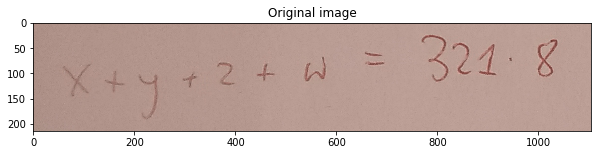

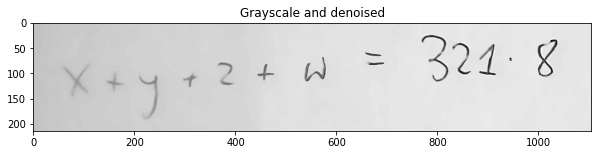

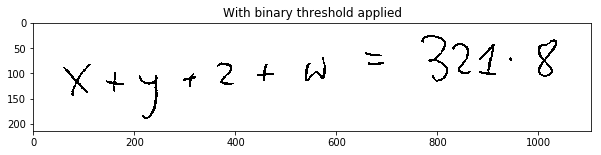

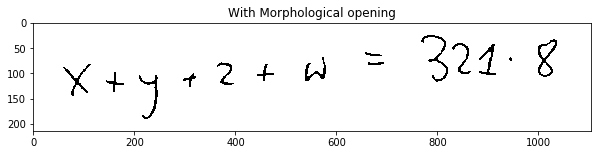

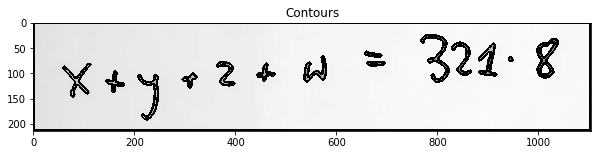

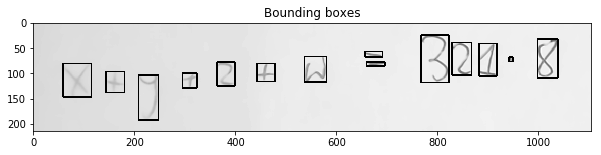

(array([[145, 145, 145, ..., 159, 159, 159],
        [145, 145, 145, ..., 159, 159, 159],
        [145, 145, 145, ..., 159, 159, 159],
        ...,
        [144, 144, 144, ..., 159, 159, 159],
        [144, 144, 144, ..., 159, 159, 159],
        [143, 143, 143, ..., 159, 159, 159]], dtype=uint8),
 [(208, 104, 40, 88),
  (296, 100, 28, 29),
  (144, 97, 37, 41),
  (443, 81, 36, 35),
  (59, 81, 56, 66),
  (660, 78, 37, 8),
  (364, 78, 36, 47),
  (942, 68, 8, 9),
  (537, 67, 44, 50),
  (657, 57, 35, 11),
  (883, 42, 35, 64),
  (829, 40, 39, 64),
  (999, 33, 40, 76),
  (768, 25, 55, 93)])

In [129]:
img = cv2.imread('equations/24.png')
process_img(img,display=True)

## Tests for whole set

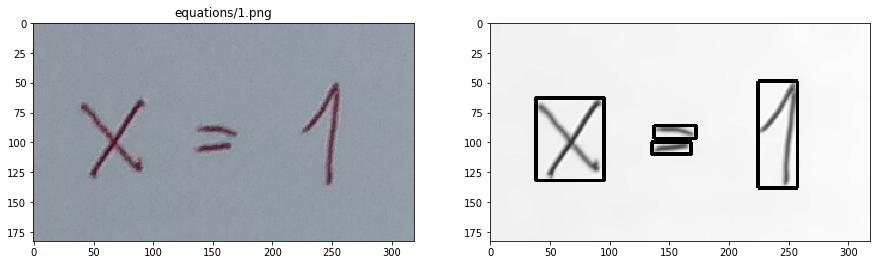

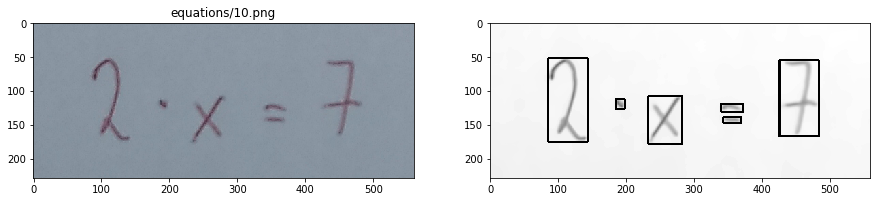

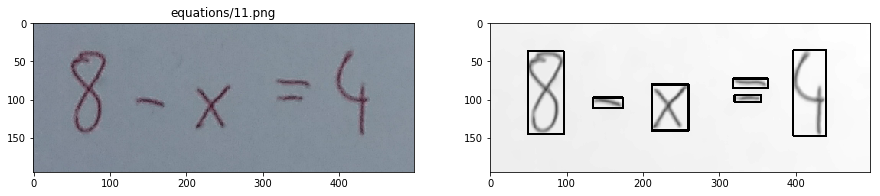

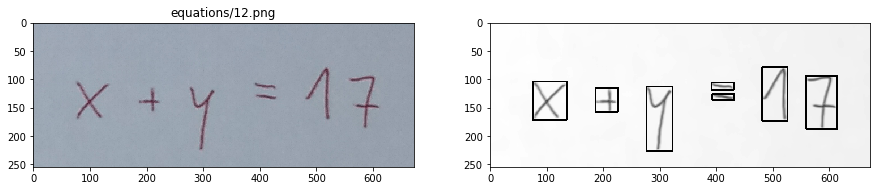

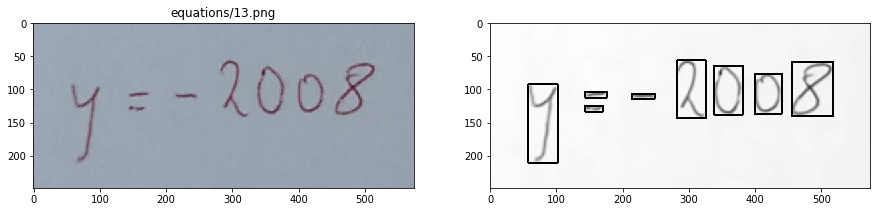

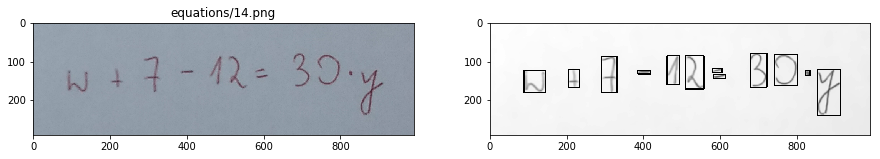

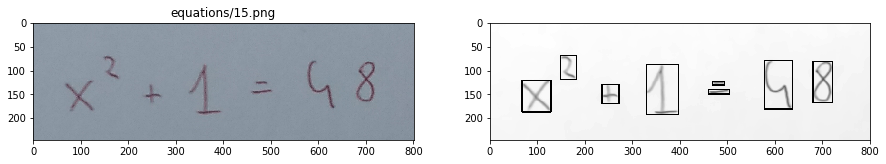

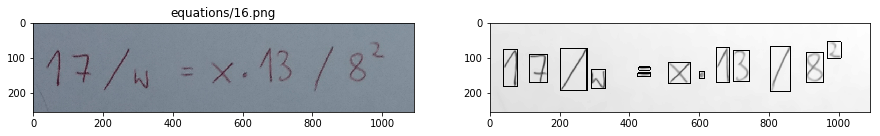

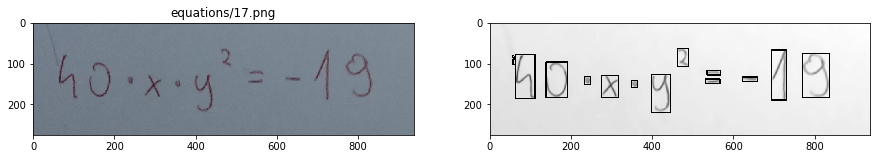

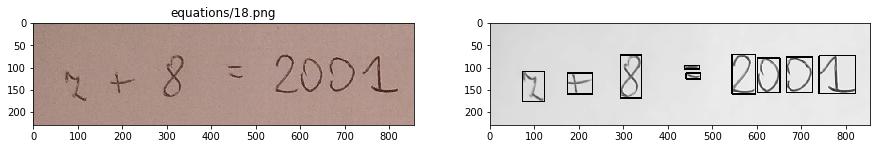

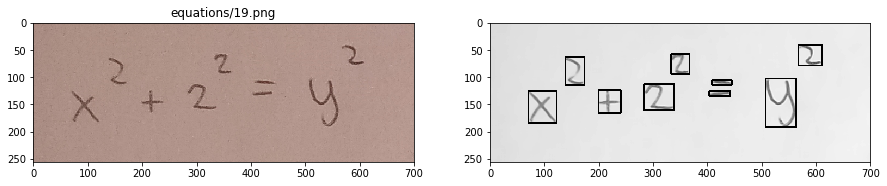

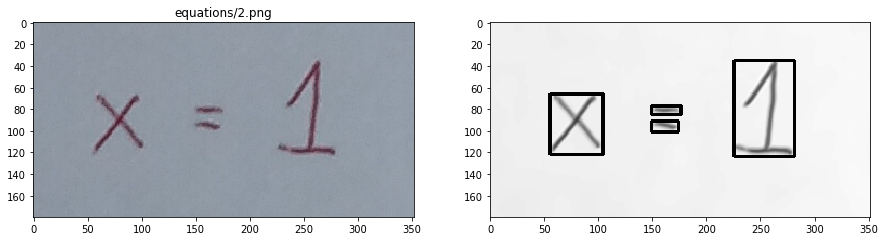

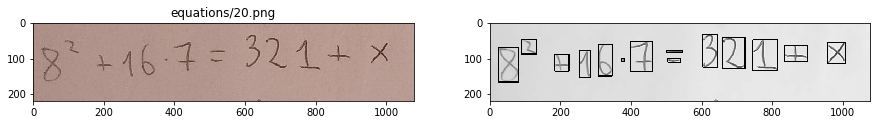

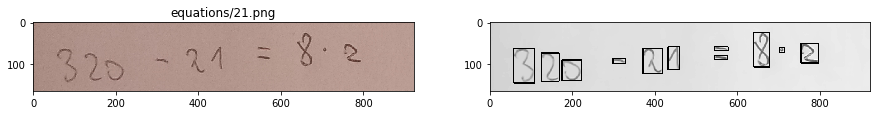

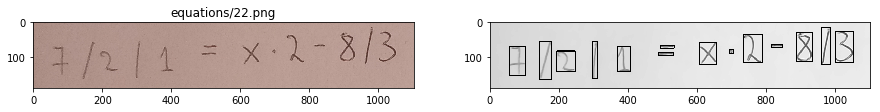

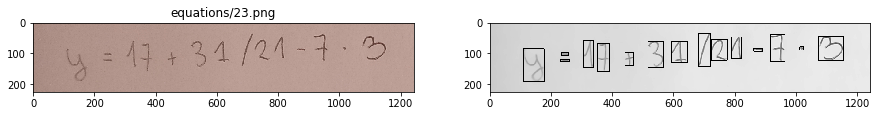

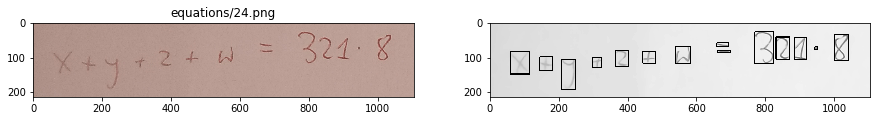

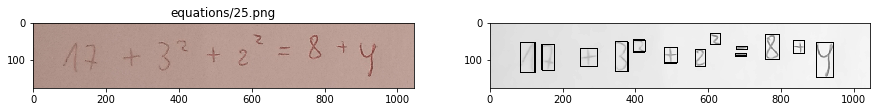

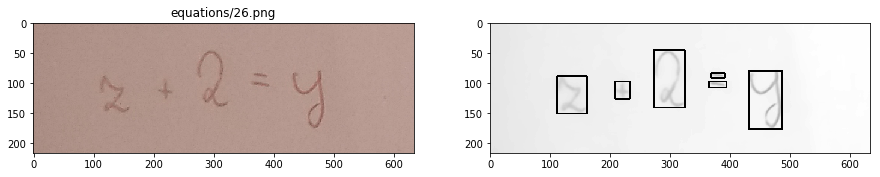

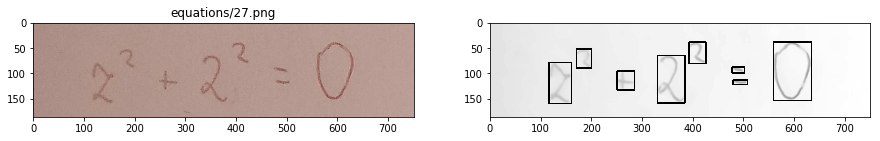

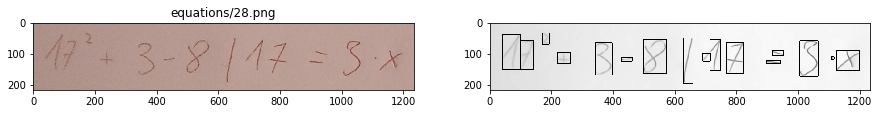

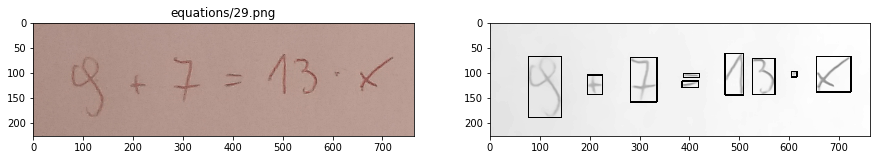

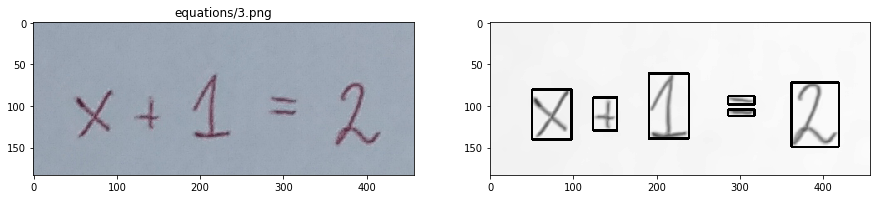

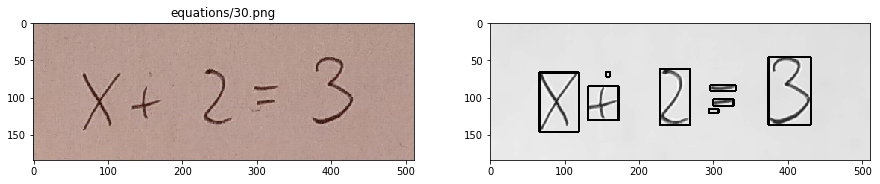

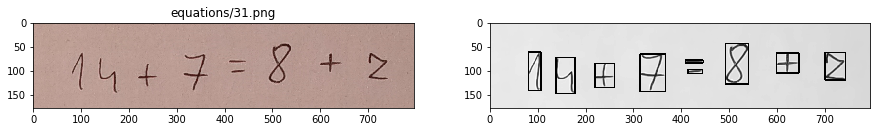

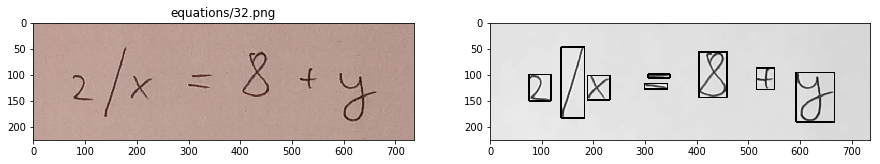

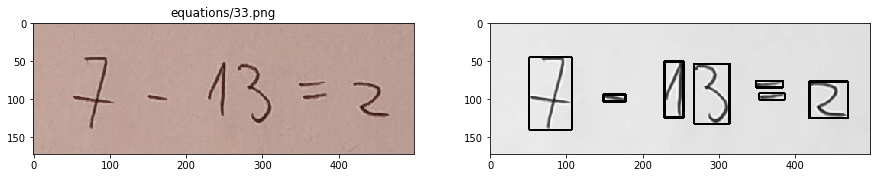

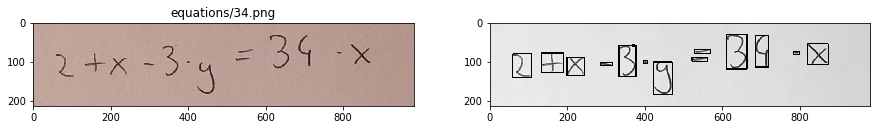

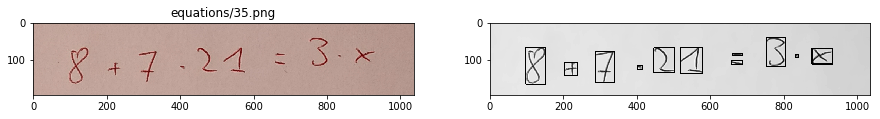

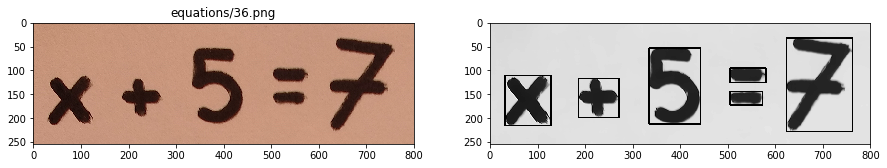

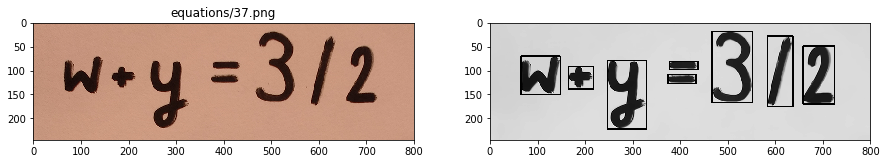

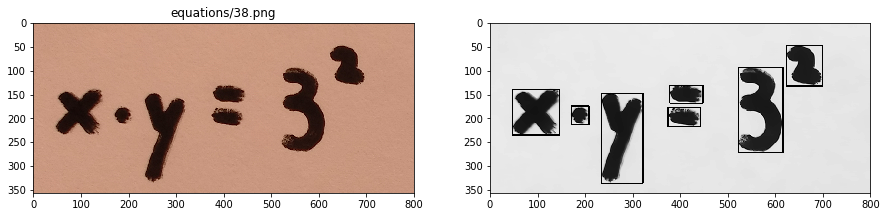

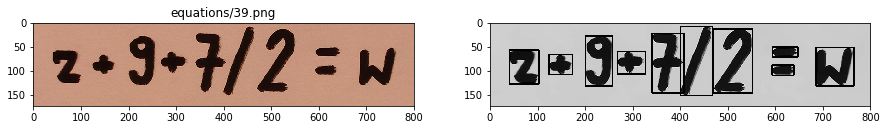

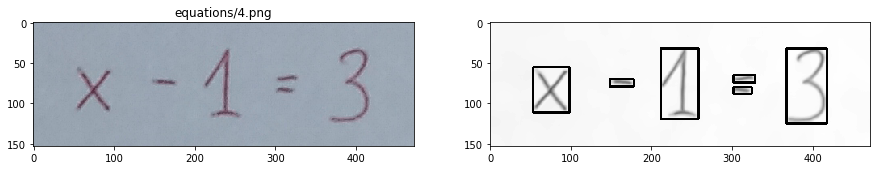

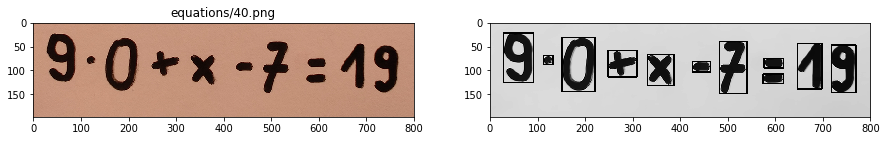

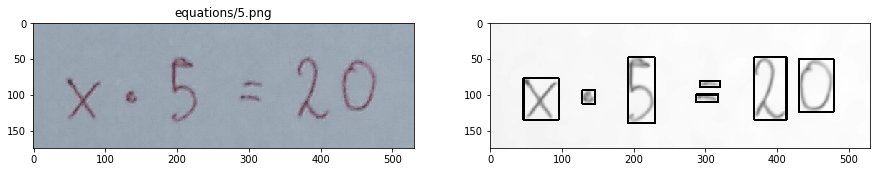

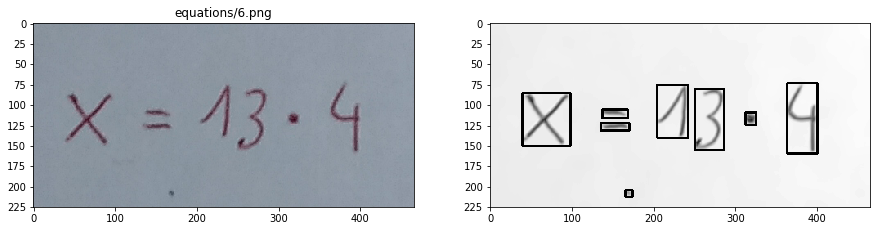

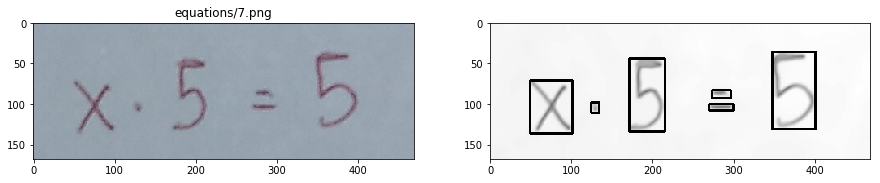

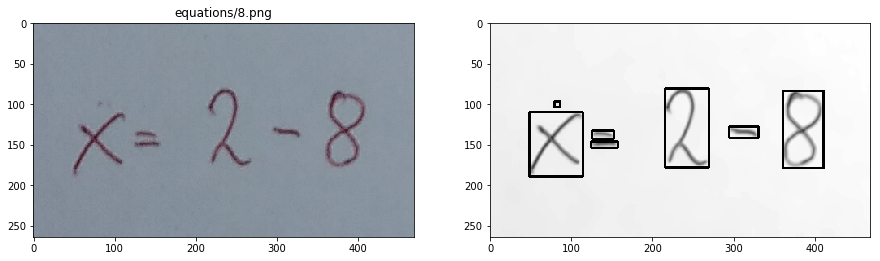

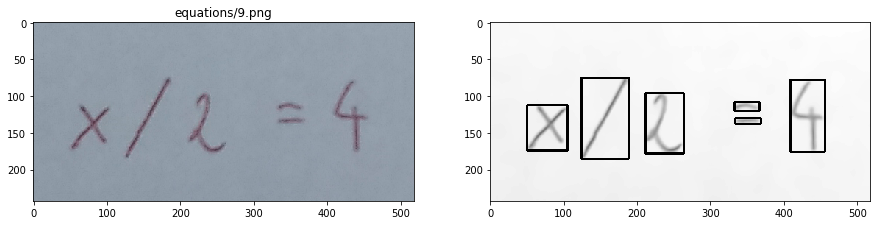

In [128]:
#Tests for whole set
DIR = 'equations'
for file in os.listdir(DIR):
    file=f'{DIR}/{file}'
    img = cv2.imread(file)
    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(file)
    img_boxes, boxes = process_img(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_boxes, cmap='gray')
    plt.show()